In [ ]:
import os, time, random
from collections import deque

import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class MultiDroneUAVEnvGym(gym.Env):
    metadata = {"render_modes": ["human"], "name": "multi_drone_uav_v7_steer30_fixedJE"}

    def __init__(
        self,
        grid_size=20,
        n_drones=3,
        n_targets=10,
        max_steps=1000,
        steer_deg=30,
        sensor_fov_deg=45,
        p_s=0.995,           # true-positive fidelity
        p_fp=None,           # false-positive prob (default: 1 - p_s)
        epsilon=0.6,         # JT threshold
        omega1=0.3,
        omega2=0.7,
        local_view=9,
        sensor_radius=3,
        reward_scale=1.0,
        update_smooth=0.3,
        seed=None,
        verbose=False,
    ):
        super().__init__()
        if seed is not None:
            np.random.seed(seed)

        assert 360 % steer_deg == 0, "steer_deg must divide 360° exactly."
        self.grid_size = grid_size
        self.n_cells = grid_size * grid_size
        self.n_drones = n_drones
        self.n_targets = n_targets
        self.max_steps = max_steps

        # Steering & headings
        self.steer_deg = float(steer_deg)
        self.n_headings = int(360 // steer_deg)
        self.headings_deg = np.arange(0, 360, steer_deg, dtype=float)

        # Sensor / reward params
        self.sensor_fov_deg = float(sensor_fov_deg)
        self.alpha_rad_fov = np.deg2rad(self.sensor_fov_deg)  # cone half-angle
        self.p_s = float(p_s)
        self.p_fp = float(p_fp if p_fp is not None else (1.0 - p_s))
        self.epsilon = float(epsilon)
        self.omega1 = float(omega1)
        self.omega2 = float(omega2)
        self.local_view = int(local_view)
        self.sensor_radius = int(sensor_radius)
        self.reward_scale = float(reward_scale)
        self.update_smooth = float(update_smooth)
        self.verbose = verbose

        # Belief / TPM
        self.belief = np.ones((self.grid_size, self.grid_size), np.float32) * 0.5

        # Action per drone: {-1,0,+1} -> turn by {-steer_deg, 0, +steer_deg}
        self.action_space = spaces.MultiDiscrete([3] * n_drones)

        # Observation
        self.observation_space = spaces.Dict({
            "local_info": spaces.Box(low=0, high=1, shape=(n_drones, local_view, local_view), dtype=np.float32),
            "TPM": spaces.Box(low=0, high=1, shape=(grid_size, grid_size), dtype=np.float32),
            "self_loc": spaces.Box(low=0, high=1, shape=(n_drones, 2), dtype=np.float32),
            "others_loc": spaces.Box(low=0, high=1, shape=(n_drones, (n_drones - 1) * 2), dtype=np.float32),
            "self_dir": spaces.Box(low=0, high=1, shape=(n_drones, self.n_headings), dtype=np.float32),
            "others_dir": spaces.Box(low=0, high=1, shape=(n_drones, (n_drones - 1) * self.n_headings), dtype=np.float32),
        })

        self.reset()

    # ---------- Entropy  ----------
    def _entropy_map(self, belief):
        b = np.clip(belief, 1e-6, 1 - 1e-6)
        return -(1.0 - b) * np.log(b)

    def _entropy_sum(self, belief):
        return float(np.sum(self._entropy_map(belief)))   # sum over all cells

    def _compute_JT(self):
        # JT = sum over cells of (1 - beta) * b   with beta = 1[b > epsilon]
        beta = (self.belief > self.epsilon).astype(np.float32)
        return float(np.sum((1.0 - beta) * self.belief))

    def _heading_onehot(self, idx):
        oh = np.zeros(self.n_headings, dtype=np.float32)
        oh[int(idx) % self.n_headings] = 1.0
        return oh

    def _get_local_patch(self, pos):
        patches = []
        r = self.local_view // 2
        for p in pos:
            x, y = np.round(p).astype(int)
            patch = np.zeros((self.local_view, self.local_view), dtype=np.float32)
            x_min, x_max = max(0, x - r), min(self.grid_size, x + r + 1)
            y_min, y_max = max(0, y - r), min(self.grid_size, y + r + 1)
            patch[:x_max - x_min, :y_max - y_min] = self.belief[x_min:x_max, y_min:y_max]
            patches.append(patch)
        return np.array(patches, dtype=np.float32)

    def _get_obs(self):
        pos_norm = self.pos / (self.grid_size - 1)
        local_info = self._get_local_patch(self.pos)
        self_loc, others_loc, self_dir, others_dir = [], [], [], []
        for i in range(self.n_drones):
            self_loc.append(pos_norm[i])
            self_dir.append(self._heading_onehot(self.heading_idx[i]))
            ol, od = [], []
            for j in range(self.n_drones):
                if j == i:
                    continue
                ol.extend(pos_norm[j])
                od.extend(self._heading_onehot(self.heading_idx[j]))
            others_loc.append(ol)
            others_dir.append(od)
        return {
            "local_info": local_info,
            "TPM": self.belief.copy(),
            "self_loc": np.array(self_loc, np.float32),
            "others_loc": np.array(others_loc, np.float32),
            "self_dir": np.array(self_dir, np.float32),
            "others_dir": np.array(others_dir, np.float32),
        }

    # ---------- Reset ----------
    def reset(self, seed=None, options=None):
        # Float positions
        self.pos = np.random.uniform(0, self.grid_size - 1, size=(self.n_drones, 2)).astype(np.float32)

        # Initial headings (restricted to cardinals, then quantized)
        cardinal_angles = np.array([0.0, 90.0, 180.0, 270.0])
        cardinal_indices = (np.round(cardinal_angles / self.steer_deg).astype(int)) % self.n_headings
        self.heading_idx = np.random.choice(cardinal_indices, size=(self.n_drones,))

        self.belief[:] = 0.5
        self.targets = {(int(x), int(y)) for x, y in np.random.randint(0, self.grid_size, size=(self.n_targets, 2))}
        self.prev_entropy_sum = self._entropy_sum(self.belief)
        self.timestep = 0

        # coverage tracking
        self.scanned_global = np.zeros((self.grid_size, self.grid_size), dtype=bool)
        self._last_turns = np.zeros(self.n_drones, dtype=int)

        return self._get_obs(), {}

    # ---------- Geometry helpers ----------
    def _idx_to_theta(self, idx):
        return np.deg2rad(self.headings_deg[int(idx) % self.n_headings])

    def _theta_to_idx(self, theta):
        theta = float((theta + 2 * np.pi) % (2 * np.pi))
        sector = int(np.round(np.rad2deg(theta) / self.steer_deg)) % self.n_headings
        return sector

    def _reflect_heading(self, theta, hit_x_wall, hit_y_wall):
        if hit_x_wall: theta = np.pi - theta     # vertical wall
        if hit_y_wall: theta = -theta            # horizontal wall
        return theta

    # ---------- Sensor cells ----------
    def _cells_in_cone(self, center, heading_idx):
        cx, cy = np.round(center).astype(int)
        cells = []
        theta = self._idx_to_theta(heading_idx)
        hv = np.array([np.cos(theta), np.sin(theta)])
        r = int(self.sensor_radius)
        for dx in range(-r, r + 1):
            for dy in range(-r, r + 1):
                xx, yy = cx + dx, cy + dy
                if not (0 <= xx < self.grid_size and 0 <= yy < self.grid_size):
                    continue
                vec = np.array([dx, dy], dtype=float)
                dist = np.linalg.norm(vec)
                if dist < 1e-6 or dist > r + 1e-9:  # exclude self & outside radius
                    continue
                vec_norm = vec / dist
                cosang = np.clip(np.dot(vec_norm, hv), -1.0, 1.0)
                ang = np.arccos(cosang)
                if ang <= self.alpha_rad_fov / 2.0:
                    cells.append((xx, yy))
        return cells

    # ---------- Bayesian update ----------
    def _bayesian_update(self, scanned_mask_per_agent):
        bonuses = np.zeros(self.n_drones, dtype=np.float32)
        p_hit, p_fp = self.p_s, self.p_fp
        for i in range(self.n_drones):
            xs, ys = np.where(scanned_mask_per_agent[i])
            for x, y in zip(xs, ys):
                b_prev = self.belief[x, y]
                has_target = (x, y) in self.targets
                # sensor outcome
                z = np.random.rand() < (p_hit if has_target else p_fp)
                # likelihoods
                p_z_T   = p_hit if z else (1 - p_hit)
                p_z_not = p_fp if z else (1 - p_fp)
                denom = p_z_T * b_prev + p_z_not * (1 - b_prev)
                if denom <= 0:
                    continue
                b_post = np.clip((p_z_T * b_prev) / denom, 1e-6, 1 - 1e-6)
                # smoothing
                self.belief[x, y] = (1.0 - self.update_smooth) * b_prev + self.update_smooth * b_post
                if z and has_target:
                    bonuses[i] += 1.0
                    self.targets.discard((x, y))
                    self.belief[x, y] = 0.999999
        return bonuses

    # ---------- Step ----------
    def step(self, actions):
        actions = np.asarray(actions)
        assert actions.shape[0] == self.n_drones

        scanned_mask_per_agent = np.zeros((self.n_drones, self.grid_size, self.grid_size), dtype=bool)

        # (A) Heading change
        for i in range(self.n_drones):
            turn = int(actions[i]) - 1
            self.heading_idx[i] = (self.heading_idx[i] + turn) % self.n_headings

        # (B) Move with bounce
        new_pos = self.pos.copy()
        for i in range(self.n_drones):
            theta = self._idx_to_theta(self.heading_idx[i])
            step_vec = np.array([np.cos(theta), np.sin(theta)], dtype=np.float32)
            trial = new_pos[i] + step_vec

            hit_x = (trial[0] < 0) or (trial[0] > self.grid_size - 1)
            hit_y = (trial[1] < 0) or (trial[1] > self.grid_size - 1)

            if hit_x or hit_y:
                theta_ref = self._reflect_heading(theta, hit_x_wall=hit_x, hit_y_wall=hit_y)
                self.heading_idx[i] = self._theta_to_idx(theta_ref)
                step_vec = np.array([np.cos(theta_ref), np.sin(theta_ref)], dtype=np.float32)
                trial = np.clip(new_pos[i] + step_vec, 0, self.grid_size - 1)

            new_pos[i] = trial

        self.pos = np.clip(new_pos, 0, self.grid_size - 1)

        # (C) Scan cones
        for i in range(self.n_drones):
            for (xx, yy) in self._cells_in_cone(self.pos[i], self.heading_idx[i]):
                scanned_mask_per_agent[i, xx, yy] = True

        # coverage bookkeeping
        union_mask = scanned_mask_per_agent.any(axis=0)
        newly_scanned = (~self.scanned_global) & union_mask
        self.scanned_global |= union_mask

        # (D) Belief update
        bonuses = self._bayesian_update(scanned_mask_per_agent)

        # (E) Compute J_T & J_E
        JT = self._compute_JT()
        E_sum_curr = self._entropy_sum(self.belief)
        JE = E_sum_curr - self.prev_entropy_sum      # equals sum(e(t+1) - e(t))
        self.prev_entropy_sum = E_sum_curr

        # Per-cell normalization for stable reward scale
        JT_norm = JT / self.n_cells
        JE_norm = JE / self.n_cells

        J_total = self.omega1 * JT_norm + self.omega2 * JE_norm
        team_reward = -J_total * self.reward_scale   # Rt = -J(t), Eq. (12)

        # (F) Anti-orbit shaping
        turn_pen = 0.0
        for a in actions:
            if a != 1:  # 1 means go straight
                turn_pen -= 0.01

        zigzag_pen = 0.0
        for i, a in enumerate(actions):
            turn = int(a) - 1
            if turn != 0 and self._last_turns[i] == -turn:
                zigzag_pen -= 0.02
            self._last_turns[i] = turn

        prox_pen = 0.0
        for i in range(self.n_drones):
            for j in range(i+1, self.n_drones):
                if np.linalg.norm(self.pos[i]-self.pos[j]) < 1.5:
                    prox_pen -= 0.05

        # (G) Final reward (coverage bonus encourages exploring new cells)
        coverage_reward = 1.0 * float(np.mean(newly_scanned))
        rewards = np.full(self.n_drones,
                          team_reward + coverage_reward + turn_pen + zigzag_pen + prox_pen,
                          np.float32)
        rewards += bonuses

        # (H) Termination
        self.timestep += 1
        terminated = (len(self.targets) == 0) or (self.timestep >= self.max_steps)
        info = {
            "JT": JT_norm,     # logged as normalized values
            "JE": JE_norm
        }
        return self._get_obs(), rewards, terminated, False, info


# ------------------------- Helpers ------------------------- #
def flatten_obs(obs_dict):
    n = obs_dict["self_loc"].shape[0]
    obs_vecs, local_maps = [], []
    for i in range(n):
        local_maps.append(obs_dict["local_info"][i])
        self_loc = obs_dict["self_loc"][i]
        others_loc = obs_dict["others_loc"][i]
        self_dir = obs_dict["self_dir"][i]
        others_dir = obs_dict["others_dir"][i]
        vec = np.concatenate([self_loc, others_loc, self_dir, others_dir])
        obs_vecs.append(vec.astype(np.float32))
    return np.array(obs_vecs, dtype=np.float32), np.array(local_maps, dtype=np.float32)


class ReplayBuffer:
    def __init__(self, capacity=200000):
        self.buffer = deque(maxlen=capacity)

    def push(self, vecs, maps, actions, rewards, next_vecs, next_maps, done,
             global_tpm, next_global_tpm):
        self.buffer.append((vecs, maps, actions, rewards, next_vecs, next_maps, done,
                            global_tpm, next_global_tpm))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        vecs, maps, actions, rewards, next_vecs, next_maps, dones, gtpms, next_gtpms = map(list, zip(*batch))
        return (
            np.array(vecs, dtype=np.float32),
            np.array(maps, dtype=np.float32),
            np.array(actions, dtype=np.int64),
            np.array(rewards, dtype=np.float32),
            np.array(next_vecs, dtype=np.float32),
            np.array(next_maps, dtype=np.float32),
            np.array(dones, dtype=np.bool_),
            np.array(gtpms, dtype=np.float32),
            np.array(next_gtpms, dtype=np.float32)
        )

    def __len__(self):
        return len(self.buffer)


# ------------------------- Actor & Critic ------------------------- #
class CNNActor(nn.Module):
    def __init__(self, vec_dim, map_size, act_dim):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
            nn.Flatten()
        )
        conv_out = 32 * (map_size // 2) * (map_size // 2)
        self.fc = nn.Sequential(
            nn.Linear(conv_out + vec_dim, 256), nn.ReLU(),
            nn.Linear(256, act_dim)  # logits
        )

    def forward(self, vec, maps):
        x1 = self.cnn(maps.unsqueeze(1))
        x = torch.cat([x1, vec], dim=1)
        return self.fc(x)  # logits


class Critic(nn.Module):
    """Centralized critic with global TPM."""
    def __init__(self, total_vec_dim, total_map_dim, total_act_dim, global_tpm_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(total_vec_dim + total_map_dim + total_act_dim + global_tpm_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, vecs, maps_flat, actions_flat, global_tpm_flat):
        x = torch.cat([vecs, maps_flat, actions_flat, global_tpm_flat], dim=1)
        return self.net(x)


# ------------------------- MADDPG ------------------------- #
class MADDPG_CNN:
    def __init__(self, n_agents, vec_dim, map_size, act_dim, global_tpm_dim,
                 lr=1e-3, gamma=0.97, tau=0.005):
        self.n_agents = n_agents
        self.vec_dim = vec_dim
        self.map_size = map_size
        self.act_dim = act_dim
        self.gamma = gamma
        self.tau = tau
        self.global_tpm_dim = global_tpm_dim

        self.actors = [CNNActor(vec_dim, map_size, act_dim).to(DEVICE) for _ in range(n_agents)]
        self.actors_target = [CNNActor(vec_dim, map_size, act_dim).to(DEVICE) for _ in range(n_agents)]
        for i in range(n_agents):
            self.actors_target[i].load_state_dict(self.actors[i].state_dict())

        total_vec = vec_dim * n_agents
        total_map = (map_size * map_size) * n_agents
        total_act = act_dim * n_agents

        self.critics = [Critic(total_vec, total_map, total_act, global_tpm_dim).to(DEVICE) for _ in range(n_agents)]
        self.critics_target = [Critic(total_vec, total_map, total_act, global_tpm_dim).to(DEVICE) for _ in range(n_agents)]
        for i in range(n_agents):
            self.critics_target[i].load_state_dict(self.critics[i].state_dict())

        self.actor_opt = [optim.Adam(a.parameters(), lr=lr) for a in self.actors]
        self.critic_opt = [optim.Adam(c.parameters(), lr=lr) for c in self.critics]

        self.entropy_coef = 0.2
        self._train_calls = 0

    def soft_update(self, target, source):
        for t, s in zip(target.parameters(), source.parameters()):
            t.data.copy_(t.data * (1.0 - self.tau) + s.data * self.tau)

    def select_action(self, obs_vecs, obs_maps, epsilon=0.3, deterministic_if_zero=True):
        actions = []
        for i in range(self.n_agents):
            vec = torch.tensor(obs_vecs[i], dtype=torch.float32, device=DEVICE).unsqueeze(0)
            maps = torch.tensor(obs_maps[i], dtype=torch.float32, device=DEVICE).unsqueeze(0)
            logits = self.actors[i](vec, maps)
            probs = F.gumbel_softmax(logits, tau=1.0, hard=False).detach().cpu().numpy()[0]
            if epsilon <= 0.0 and deterministic_if_zero:
                a = int(np.argmax(probs))
            else:
                if np.random.rand() < epsilon:
                    a = np.random.randint(self.act_dim)
                else:
                    probs = np.clip(probs, 1e-8, 1.0)
                    probs /= probs.sum()
                    a = int(np.random.choice(self.act_dim, p=probs))
            actions.append(a)
        return np.array(actions, dtype=np.int64)

    def train(self, batch):
        (vecs, maps, actions, rewards, next_vecs, next_maps, dones,
         gtpms, next_gtpms) = batch
        self._train_calls += 1
        self.entropy_coef = max(0.01, self.entropy_coef * 0.999)

        B = vecs.shape[0]

        vecs_t = torch.tensor(vecs, dtype=torch.float32, device=DEVICE)
        maps_t = torch.tensor(maps, dtype=torch.float32, device=DEVICE)
        acts_t = torch.tensor(actions, dtype=torch.long, device=DEVICE)
        rewards_t = torch.tensor(rewards, dtype=torch.float32, device=DEVICE)
        next_vecs_t = torch.tensor(next_vecs, dtype=torch.float32, device=DEVICE)
        next_maps_t = torch.tensor(next_maps, dtype=torch.float32, device=DEVICE)
        dones_t = torch.tensor(dones, dtype=torch.float32, device=DEVICE).view(B, 1)
        gtpms_t = torch.tensor(gtpms, dtype=torch.float32, device=DEVICE)
        next_gtpms_t = torch.tensor(next_gtpms, dtype=torch.float32, device=DEVICE)

        vecs_joint = vecs_t.view(B, -1)
        maps_joint = maps_t.view(B, -1)
        next_vecs_joint = next_vecs_t.view(B, -1)
        next_maps_joint = next_maps_t.view(B, -1)

        # one-hot current actions
        actions_onehot = torch.zeros(B, self.act_dim * self.n_agents, dtype=torch.float32, device=DEVICE)
        for i in range(self.n_agents):
            actions_onehot[torch.arange(B), i * self.act_dim + acts_t[:, i]] = 1.0

        # target actions (soft)
        with torch.no_grad():
            next_actions_onehot = torch.zeros_like(actions_onehot)
            for i in range(self.n_agents):
                logits = self.actors_target[i](next_vecs_t[:, i, :], next_maps_t[:, i, :, :])
                probs = F.gumbel_softmax(logits, tau=1.0, hard=False)
                next_actions_onehot[:, i * self.act_dim:(i + 1) * self.act_dim] = probs

        # critic update
        td_losses = []
        for i in range(self.n_agents):
            self.critic_opt[i].zero_grad()
            target_Q = self.critics_target[i](next_vecs_joint, next_maps_joint, next_actions_onehot, next_gtpms_t)
            y = rewards_t[:, i].unsqueeze(1) + (1.0 - dones_t) * (self.gamma * target_Q)
            curr_Q = self.critics[i](vecs_joint, maps_joint, actions_onehot, gtpms_t)
            loss_critic = F.mse_loss(curr_Q, y)
            loss_critic.backward()
            nn.utils.clip_grad_norm_(self.critics[i].parameters(), 1.0)
            self.critic_opt[i].step()
            td_losses.append(loss_critic.detach().item())
        td_loss_mean = float(np.mean(td_losses))

        # actor update (with entropy reg)
        entropies = []
        for i in range(self.n_agents):
            self.actor_opt[i].zero_grad()
            current_actions = []
            agent_entropies = []
            for j in range(self.n_agents):
                logits = self.actors[j](vecs_t[:, j, :], maps_t[:, j, :, :])
                probs = F.gumbel_softmax(logits, tau=1.0, hard=False)
                current_actions.append(probs)
                ent = -(probs * (probs.clamp_min(1e-8)).log()).sum(dim=1).mean()
                agent_entropies.append(ent)
            current_actions = torch.cat(current_actions, dim=-1)
            H = torch.stack(agent_entropies).mean()
            entropies.append(H.detach().item())

            actor_Q = self.critics[i](vecs_joint, maps_joint, current_actions, gtpms_t)
            loss_actor = -actor_Q.mean() - self.entropy_coef * H
            loss_actor.backward()
            nn.utils.clip_grad_norm_(self.actors[i].parameters(), 1.0)
            self.actor_opt[i].step()

        policy_entropy_mean = float(np.mean(entropies))

        for i in range(self.n_agents):
            self.soft_update(self.actors_target[i], self.actors[i])
            self.soft_update(self.critics_target[i], self.critics[i])

        return {"td_loss": td_loss_mean, "policy_entropy": policy_entropy_mean, "entropy_coef": self.entropy_coef}


# ------------------------- Training ------------------------- #
def train_run(episodes=300, seed=42, VERBOSE=True):
    env = MultiDroneUAVEnvGym(n_drones=3, n_targets=10, seed=seed, verbose=VERBOSE)
    obs_dict, _ = env.reset()
    obs_vecs, obs_maps = flatten_obs(obs_dict)

    n_agents = obs_vecs.shape[0]
    vec_dim = obs_vecs.shape[1]
    map_size = obs_maps.shape[1]
    act_dim = int(env.action_space.nvec[0])
    global_tpm_dim = env.grid_size * env.grid_size

    maddpg = MADDPG_CNN(n_agents, vec_dim, map_size, act_dim, global_tpm_dim,
                         lr=1e-3, gamma=0.97, tau=0.005)
    buffer = ReplayBuffer(150000)

    episode_rewards = []
    avg50 = []

    start_time = time.time()
    for ep in range(episodes):
        obs_dict, _ = env.reset()
        obs_vecs, obs_maps = flatten_obs(obs_dict)
        global_tpm = obs_dict["TPM"].astype(np.float32).reshape(-1)

        ep_reward = 0.0
        eps = max(0.3, 0.9 * np.exp(-ep / 250.0))  # slower decay

        jt_list, je_list = [], []
        td_list, ent_list = [], []

        for _ in range(env.max_steps):
            actions = maddpg.select_action(obs_vecs, obs_maps, epsilon=eps)
            next_obs, rewards, done, _, info = env.step(actions)

            next_vecs, next_maps = flatten_obs(next_obs)
            next_global_tpm = next_obs["TPM"].astype(np.float32).reshape(-1)

            buffer.push(obs_vecs, obs_maps, actions, rewards, next_vecs, next_maps, done,
                        global_tpm, next_global_tpm)

            obs_vecs, obs_maps = next_vecs, next_maps
            global_tpm = next_global_tpm
            ep_reward += float(np.mean(rewards))
            jt_list.append(info["JT"]); je_list.append(info["JE"])

            if len(buffer) > 2000:
                batch = buffer.sample(256)
                stats = maddpg.train(batch)
                td_list.append(stats["td_loss"])
                ent_list.append(stats["policy_entropy"])

            if done:
                break

        episode_rewards.append(ep_reward)
        avg50.append(float(np.mean(episode_rewards[-50:])))

        if (ep + 1) % 10 == 0 or VERBOSE:
            elapsed = time.time() - start_time
            steps = len(jt_list) if jt_list else 0
            jt_end = jt_list[-1] if jt_list else np.nan
            td_mean = float(np.mean(td_list)) if td_list else np.nan
            ent_mean = float(np.mean(ent_list)) if ent_list else np.nan
            print(f"Ep {ep+1:04d} | Steps={steps} | Rsum={ep_reward:.2f} | eps={eps:.3f} | "
                  f"JT_end={jt_end:.4f} | JT_mean={np.mean(jt_list):.4f} | "
                  f"JE_mean={np.mean(je_list):.4f} | TD={td_mean:.4f} | πH={ent_mean:.3f}")

    os.makedirs("checkpoints", exist_ok=True)
    for i, actor in enumerate(maddpg.actors):
        torch.save(actor.state_dict(), f"checkpoints/actor_{i}.pth")
    np.savez("checkpoints/training_rewards.npz",
             rewards=np.array(episode_rewards), avg50=np.array(avg50))

    return maddpg, env, episode_rewards, avg50


def plot_rewards(episode_rewards, avg50, window=50):
    plt.figure(figsize=(10, 5))
    plt.plot(episode_rewards, label='Episode Reward', alpha=0.6)
    if len(episode_rewards) >= window:
        plt.plot(range(len(avg50)), avg50, label=f'{window}-Episode Avg')
    plt.xlabel('Episode')
    plt.ylabel('Average Team Reward')
    plt.title('Training Progress — Multi-Drone MADDPG-CNN (Normalized JE/JT)')
    plt.legend(); plt.grid(True); plt.show()


# ------------------------- Main ------------------------- #
if __name__ == "__main__":
    EPISODES = 300
    maddpg, env, rewards, avg50 = train_run(episodes=EPISODES, seed=42, VERBOSE=False)
    plot_rewards(rewards, avg50, window=50)
    print("✅ Saved checkpoints in ./checkpoints (actor_*.pth) and training curves npz.")


KeyboardInterrupt: 

✅ Loaded trained actor weights!
✅ Saved 151 frames to `frames/`
🎬 GIF saved as simulation.gif


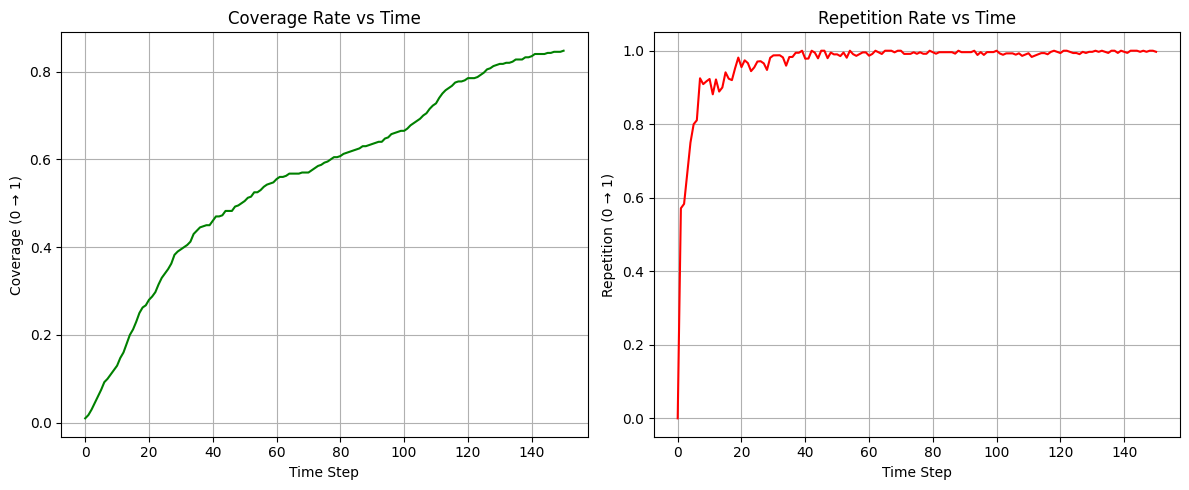

✅ Simulation + Coverage & Repetition Metrics Complete!


In [ ]:
# ===== Load Trained MADDPG + Run Simulation + Make GIF + Plot Coverage/Repetition =====

import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import imageio

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Recreate env + agent
env = MultiDroneUAVEnvGym(n_drones=3, n_targets=10, seed=42)
obs_dict, _ = env.reset()
obs_vecs, obs_maps = flatten_obs(obs_dict)

n_agents = obs_vecs.shape[0]
vec_dim = obs_vecs.shape[1]
map_size = obs_maps.shape[1]
act_dim = int(env.action_space.nvec[0])
global_tpm_dim = env.grid_size * env.grid_size

maddpg = MADDPG_CNN(n_agents, vec_dim, map_size, act_dim, global_tpm_dim,
                     lr=1e-3, gamma=0.97, tau=0.005)

# Load trained actor weights
for i in range(maddpg.n_agents):
    maddpg.actors[i].load_state_dict(torch.load(f"checkpoints/actor_{i}.pth", map_location=DEVICE))
    maddpg.actors[i].eval()

print("✅ Loaded trained actor weights!")


def simulate_and_collect_metrics(maddpg, env, steps=200, out_dir="frames"):
    os.makedirs(out_dir, exist_ok=True)

    obs, _ = env.reset()
    obs_vecs, obs_maps = flatten_obs(obs)

    coverage_list = []
    repetition_list = []

    for t in range(steps):
        scanned_before = env.scanned_global.copy()

        actions = maddpg.select_action(obs_vecs, obs_maps, epsilon=0.0)
        obs, rewards, done, _, info = env.step(actions)
        obs_vecs, obs_maps = flatten_obs(obs)

        # -------- Coverage Rate --------
        coverage_rate = env.scanned_global.sum() / (env.grid_size * env.grid_size)
        coverage_list.append(coverage_rate)

        # -------- Repetition Rate --------
        newly_scanned = np.logical_and(env.scanned_global, ~scanned_before)
        repeated_cells = np.logical_and(env.scanned_global, scanned_before)

        new_count = newly_scanned.sum()
        rep_count = repeated_cells.sum()
        total = new_count + rep_count
        repetition_rate = rep_count / total if total > 0 else 0
        repetition_list.append(repetition_rate)

        # -------- Visualization Frame --------
        fig, ax = plt.subplots(figsize=(6,6))
        ax.imshow(env.belief, cmap='viridis', origin='lower', vmin=0, vmax=1)

        for i in range(env.n_drones):
            x, y = env.pos[i]
            ax.scatter(y, x, c='red', s=120, edgecolors='white', linewidths=1.5)
            theta = env._idx_to_theta(env.heading_idx[i])
            ax.arrow(y, x, np.sin(theta)*0.6, np.cos(theta)*0.6,
                     head_width=0.35, head_length=0.45, color='white')

        for tx, ty in env.targets:
            ax.scatter(ty, tx, c='yellow', marker='x', s=80)

        ax.set_title(f"Step {t} | Cov={coverage_rate:.3f} | Rep={repetition_rate:.3f}")
        ax.set_xticks([]); ax.set_yticks([])

        fig.savefig(f"{out_dir}/frame_{t:04d}.png")
        plt.close(fig)

        if done:
            break

    print(f"✅ Saved {t+1} frames to `{out_dir}/`")
    return coverage_list, repetition_list


def make_gif(out_dir="frames", gif_name="simulation.gif", fps=8):
    images = []
    for f in sorted(os.listdir(out_dir)):
        if f.endswith(".png"):
            images.append(imageio.v3.imread(os.path.join(out_dir, f)))
    imageio.mimsave(gif_name, images, fps=fps)
    print(f"🎬 GIF saved as {gif_name}")


# Run simulation
coverage, repetition = simulate_and_collect_metrics(maddpg, env, steps=200, out_dir="frames")
make_gif("frames", "simulation.gif", fps=8)

# ---------- Plot Coverage & Repetition ----------
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(coverage, label="Coverage Rate", color='green')
plt.xlabel("Time Step"); plt.ylabel("Coverage (0 → 1)")
plt.title("Coverage Rate vs Time"); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(repetition, label="Repetition Rate", color='red')
plt.xlabel("Time Step"); plt.ylabel("Repetition (0 → 1)")
plt.title("Repetition Rate vs Time"); plt.grid(True)

plt.tight_layout()
plt.show()

print("✅ Simulation + Coverage & Repetition Metrics Complete!")


In [ ]:
from google.colab import files
files.download("simulation.gif")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>